### Integrating stem cells scRNA-seq datasets across human and mouse with `SATURN`

- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 3rd September 2024
- **Last modified date:** 4th September 2024

This notebook is created to integrate human gut fetal stem cells from Elementaite, 2021 dataset and mouse gut stem cells from Haber, 2017 study using `SATURN` tool. 

#### Import packages

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import pickle

#### Make csv

In [29]:
df = pd.DataFrame(columns=["path", "species", "embedding_path"])
df["species"] = ["human", "mouse"]
df["path"] = ["data/FetalSC_for_SATURN.h5ad", "data/Haber_2017_Smartseq_stem_cells_remapped.h5ad"]
human_embedding_path = "database_data/ESM2_human_embedding.torch"
mouse_embedding_path = "database_data/ESM2_mouse_embedding.torch"
df["embedding_path"] = [human_embedding_path, mouse_embedding_path]
df.to_csv("data/SATURN_human_mouse.csv", index=False)

#### Create a cell type map

In [25]:
df = pd.DataFrame(columns=["human_cell_type", "mouse_cell_type"])
df["human_cell_type"] = ["MTRNR2L12", 'RPS10', 'FXYD3', "Stem cell", "Stem cell"]
df["mouse_cell_type"] = ["Stem cell", "Stem cell", "Stem cell", "LGR5+ stem cell", "LGR5- stem cell"]
df.to_csv("data/cell_type_map.csv", index=False)

#### Train SATURN

In [26]:
# this line takes a while so it was run in terminal
!python3 /saturn/train-saturn.py --in_data=data/SATURN_human_mouse.csv \
                              --in_label_col=cell_type --ref_label_col=cell_type \
                              --num_macrogenes=4000 --hv_genes=8000 \
                              --centroids_init_path=/saturn_results/hm_centroids.pkl \
                              --ct_map_path=data/cell_type_map.csv \
                              --work_dir=/saturn_results \
                              --device_num=0

Using Device 0
Set seed to 0
After loading the anndata human View of AnnData object with n_obs × n_vars = 7817 × 15488
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'species', 'species_type_label', 'truth_labels', 'ref_labels'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Age_colors', 'Age_group_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_s

#### Load SATURN Results

In [15]:
adata = sc.read("data/saturn_results/saturn_results/test256_data_FetalSC_for_SATURN_Haber_2017_Smartseq_stem_cells_remapped_org_saturn_seed_0.h5ad")
adata

AnnData object with n_obs × n_vars = 8306 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species'
    obsm: 'macrogenes'

In [16]:
adata.obs['labels2'] = adata.obs['labels2'].cat.add_categories(['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'])
adata.obs.loc[adata.obs['labels2'] == 'MTRNR2L12', 'labels2'] = 'MTRNR2L12+ASS1+_SC'
adata.obs.loc[adata.obs['labels2'] == 'RPS10', 'labels2'] = 'RPS10+_RPS17+_SC'
adata.obs.loc[adata.obs['labels2'] == 'FXYD3', 'labels2'] = 'FXYD3+_CKB+_SC'

adata.obs['labels2'] = adata.obs['labels2'].cat.remove_categories(['MTRNR2L12', 'RPS10', 'FXYD3'])

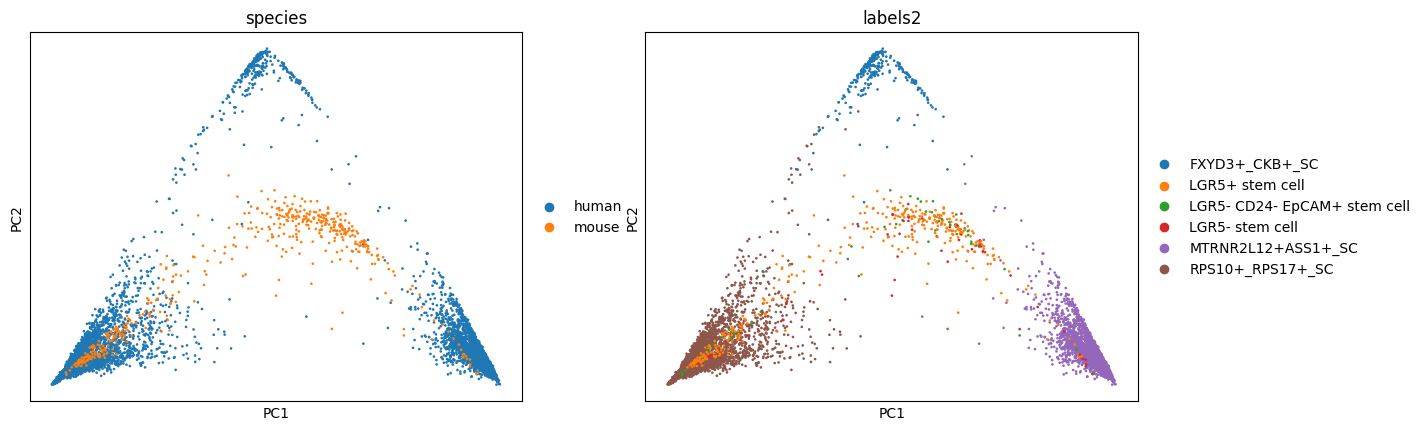

In [17]:
sc.pp.pca(adata)
sc.pl.pca(adata,color=["species", "labels2"])

In [18]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/amaguza/miniforge3/envs/SATURN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


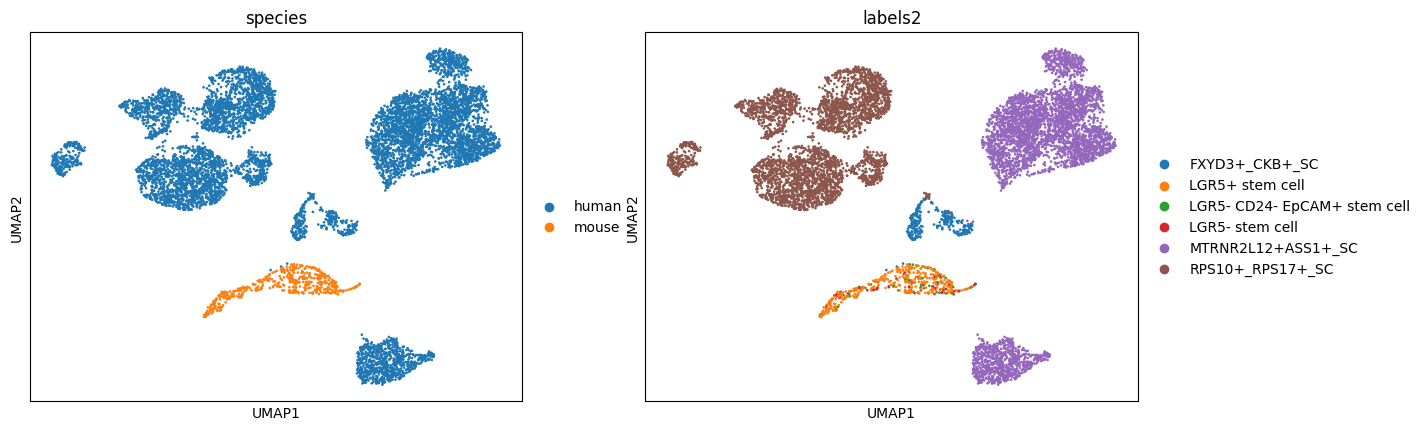

In [19]:
sc.pl.umap(adata,color=["species", "labels2"])

In [20]:
adata.obsm['X_saturn'] = adata.X.copy()

In [21]:
adata.write("data/saturn_results/saturn_results/test256_data_FetalSC_for_SATURN_Haber_2017_Smartseq_stem_cells_remapped_org_saturn_seed_0.h5ad")

#### Macrogene Differential Expression

In [22]:
with open("data/saturn_results/saturn_results/test256_data_FetalSC_for_SATURN_Haber_2017_Smartseq_stem_cells_remapped_org_saturn_seed_0_genes_to_macrogenes.pkl", "rb") as f:
    macrogene_weights = pickle.load(f)

In [23]:
len(macrogene_weights)

16000

In [24]:
macrogene_adata = sc.AnnData(adata.obsm["macrogenes"])
macrogene_adata.obs = adata.obs

In [25]:
sc.tl.rank_genes_groups(macrogene_adata, groupby="labels2", method="wilcoxon")

/home/amaguza/miniforge3/envs/SATURN/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 10000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


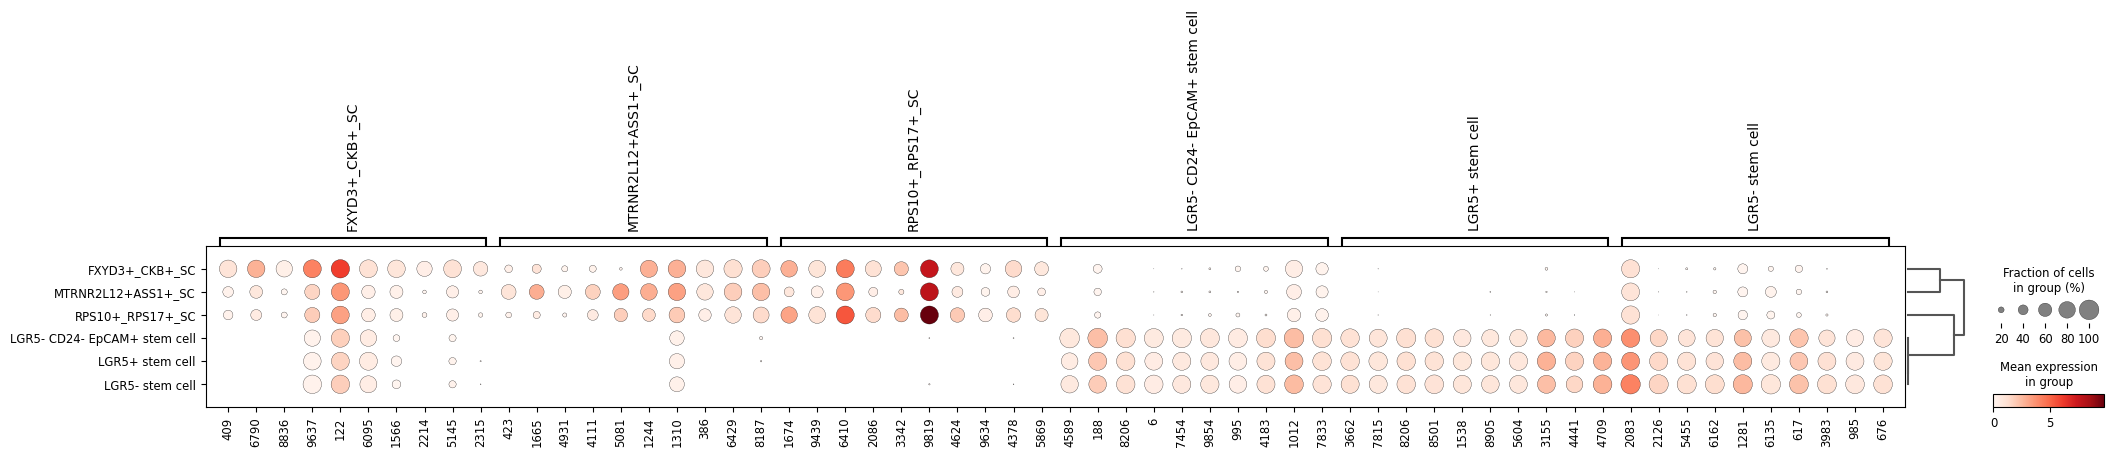

In [26]:
sc.pl.rank_genes_groups_dotplot(macrogene_adata)

* Get orthologues from macrogenes

In [27]:
def get_top_gene_for_species(macrogene, species, macrogene_weights):
    scores = {}
    for gene, score in macrogene_weights.items():
        if gene.startswith(species):
            scores[gene] = score[int(macrogene)]
    
    if scores:
        return max(scores, key=scores.get)
    return None

In [28]:
def compile_macrogene_top_genes(macrogenes, macrogene_weights):
    results = []
    for macrogene in macrogenes:
        top_human_gene = get_top_gene_for_species(macrogene, 'human', macrogene_weights)
        top_mouse_gene = get_top_gene_for_species(macrogene, 'mouse', macrogene_weights)
        
        if top_human_gene:
            top_human_gene = top_human_gene.split('_', 1)[1] 
        if top_mouse_gene:
            top_mouse_gene = top_mouse_gene.split('_', 1)[1]
        
        results.append({
            'Macrogene': macrogene,
            'Top Human Gene': top_human_gene,
            'Top Mouse Gene': top_mouse_gene
        })
    
    return pd.DataFrame(results)

In [29]:
macrogenes = list(range(10000))

In [30]:
df = compile_macrogene_top_genes(macrogenes, macrogene_weights)

In [31]:
print(df.head())

   Macrogene Top Human Gene Top Mouse Gene
0          0           PAK6           Pak4
1          1         PPFIA2         Ppfia4
2          2         TRIM71         Trim71
3          3          ETNK1           Chka
4          4       ANKRD36C         Bhlhb9


In [13]:
df.to_csv('data/saturn_results/macrogenes_derived_human_mouse_orthologues_10K.csv', index=False)